#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(inputs[0])[0], tf.shape(inputs[0])[1]))        
        return inputs[0] + tf.keras.backend.exp(inputs[1]/2) * epsilon     

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

**ANSWER** <br>
For the encoder, I chose to use 3 dense layers with sizes 256, 128 and 32 respectively, in order to have a smoother compression of the input. Regarding the activation functions, I used the tanh function for all the layers, since this combination was the one that performed the best among the one that I have tested in terms of the overall total loss of the variational autoencoder:

* relu relu relu ----- loss: 27.3823 - reconstruction_loss: 23.3196 - kl_loss: 4.0627

* relu tanh relu ----- loss: 27.3842 - reconstruction_loss: 23.3410 - kl_loss: 4.0432

* sigmoid sigmoid sigmoid ----- loss: 29.3955 - reconstruction_loss: 26.9838 - kl_loss: 2.4117

* sigmoid tanh sigmoid ----- loss: 28.6473 - reconstruction_loss: 25.7366 - kl_loss: 2.9107

* tanh tanh tanh ----- loss: 27.4689 - reconstruction_loss: 23.4289 - kl_loss: 4.0400

* tanh sigmoid tanh ----- loss: 28.9478 - reconstruction_loss: 26.2287 - kl_loss: 2.7191

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))

x = tf.keras.layers.Dense(256, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_var = tf.keras.layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           4128        dense_1[0][0]                    
____________________________________________________________________________________________

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

**ANSWER** <br>
For the decoder, I used a specular architecture with respect to the encoder architecture. For the output layer I used the sigmoid activation function since in the input space we normalized the pixel values of the images to be in [0,1], therefore we want that also output values must be in [0,1]. If for instance I used ReLu as activation function for the output layer, it is possible to notice an increase of the total loss (even if we obtain a reduction on the KL divergence):

* sigmoid ----- loss: 27.3732 - reconstruction_loss: 23.1991 - kl_loss: 4.1741

* relu ----- loss: 34.4175 - reconstruction_loss: 33.3358 - kl_loss: 1.0817

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = tf.keras.layers.Dense(32, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               201488    
Total params: 238,832
Trainable params: 238,832
Non-trainable params: 0
_________________________________________________________________


##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction)))
            
            kl_loss = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 3s 4ms/step - loss: 35.4407 - reconstruction_loss: 34.7383 - kl_loss: 0.7025
Epoch 2/30
391/391 [==============================] - 1s 4ms/step - loss: 31.2075 - reconstruction_loss: 29.4851 - kl_loss: 1.7223
Epoch 3/30
391/391 [==============================] - 1s 4ms/step - loss: 30.1717 - reconstruction_loss: 27.8555 - kl_loss: 2.3162
Epoch 4/30
391/391 [==============================] - 1s 4ms/step - loss: 29.6762 - reconstruction_loss: 27.0735 - kl_loss: 2.6026
Epoch 5/30
391/391 [==============================] - 1s 4ms/step - loss: 29.3242 - reconstruction_loss: 26.5164 - kl_loss: 2.8078
Epoch 6/30
391/391 [==============================] - 1s 4ms/step - loss: 29.0634 - reconstruction_loss: 26.0825 - kl_loss: 2.9808
Epoch 7/30
391/391 [==============================] - 1s 4ms/step - loss: 28.8623 - reconstruction_loss: 25.7417 - kl_loss: 3.1206
Epoch 8/30
391/391 [==============================] - 1s 4ms/step - loss: 28.6913 -

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

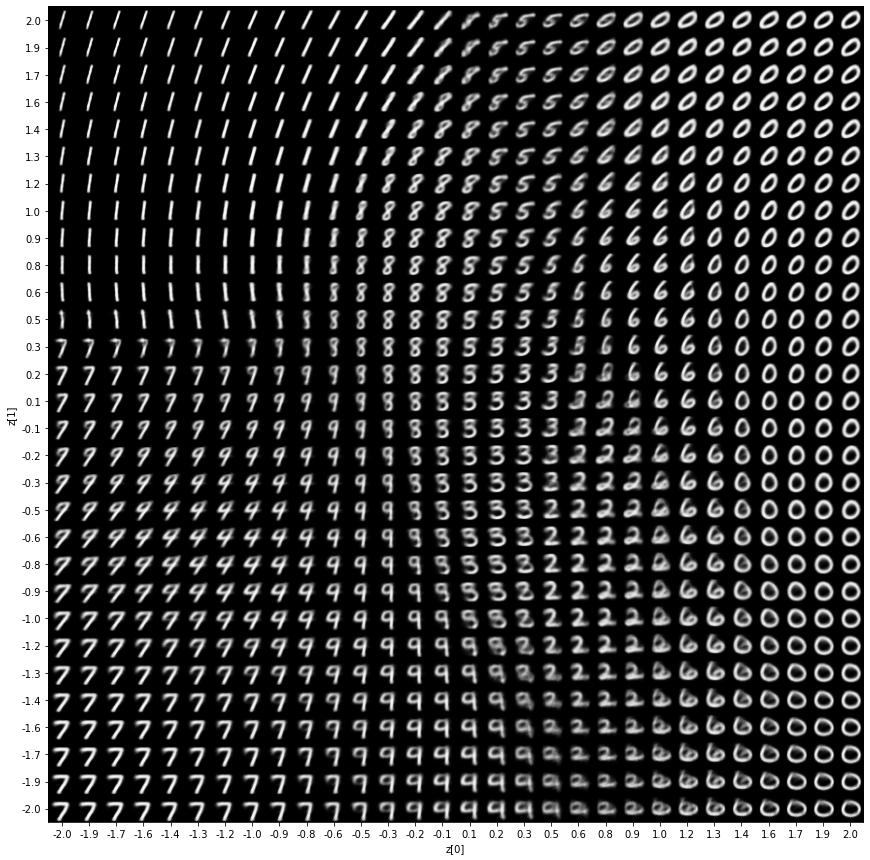

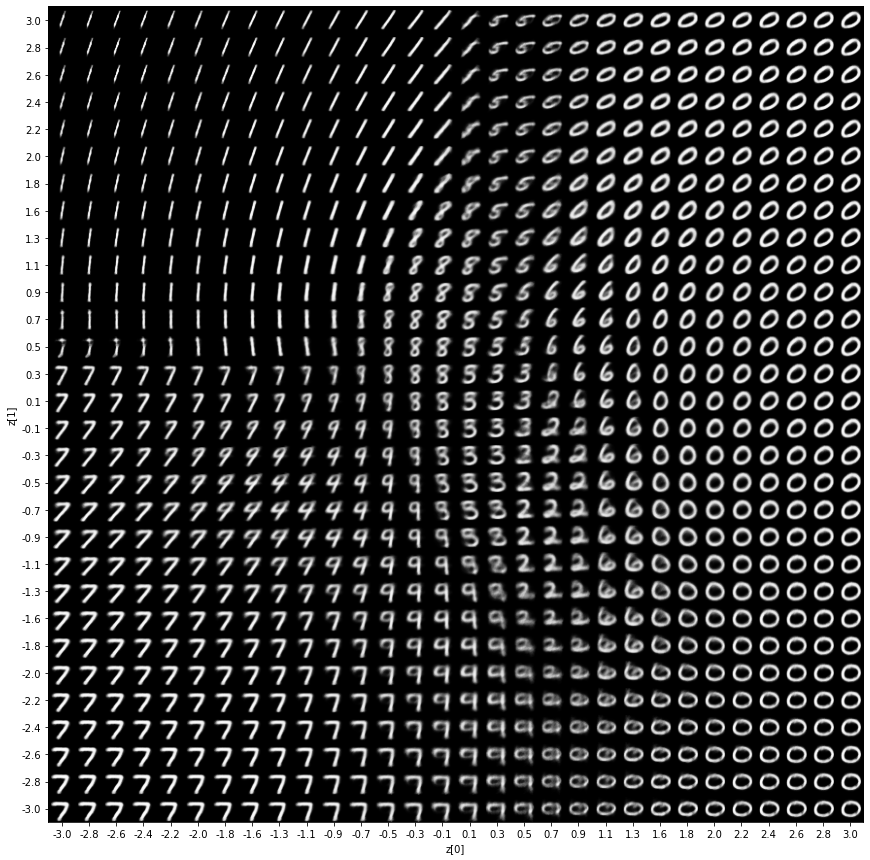

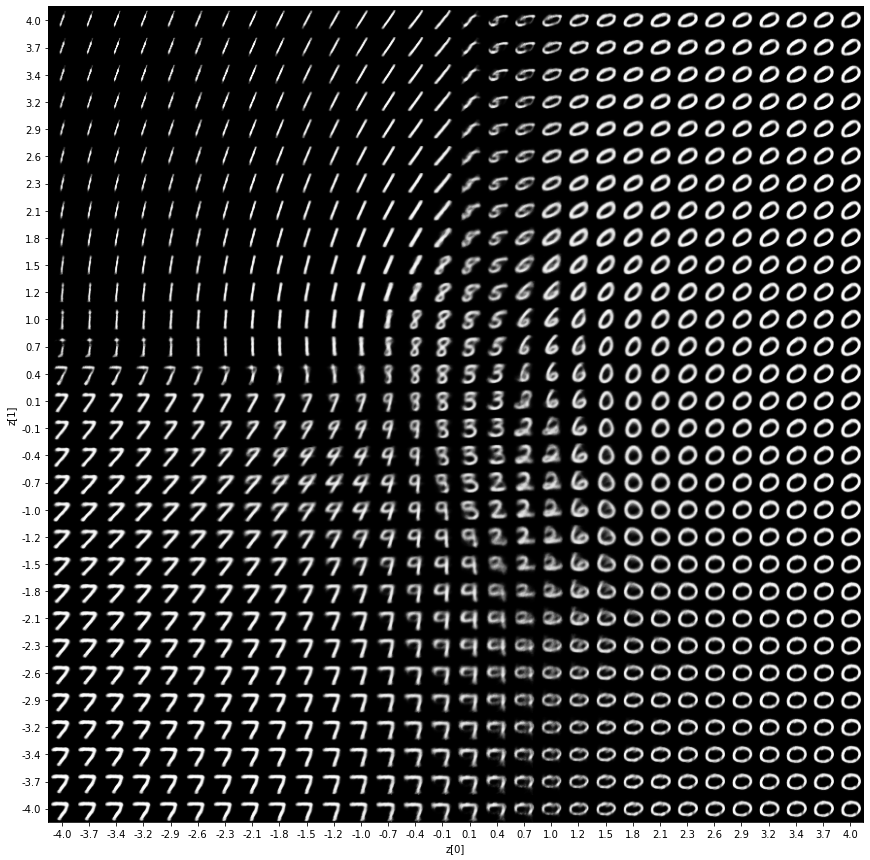

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 
plot_latent(encoder, decoder, 3.0, 30) 
plot_latent(encoder, decoder, 4.0, 30) 

#[TO COMPLETE] explore with different "scale"

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

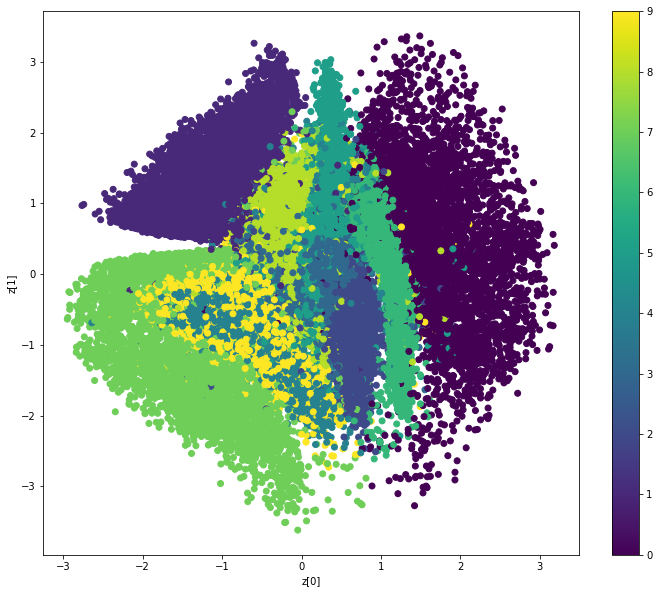

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**ANSWER** 

By increasing the scale parameter in the latent space plot it is possible to notice how more 1, 0 and 7 digits are generated (probably due to the enlargement of the considered interval). Regarding the data generation plot, in general we have well-defined clusters for digits 0, 1, 2, 6, 7, 8, while in the generation of digits 3, 4 and 9 the distributions overlap each other probably due to similarity in shape of the digits. These results were obtained with the best architecture I have found, therefore when I modified the hyper-parameters of the VAE it resulted in an increase of the total loss that decreased the data generation capabilities and accuracy.